In [1]:
# TO BE RUN ONLY ONCE!
import os
os.chdir("../../../")

In [2]:
os.getcwd()

'/home/mario/PhD/spatial_lda'

In [3]:
## *******************************************************************************

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import subprocess
import pymc3 as pm
import seaborn as sns

import spatial_mix.hdp_utils as hdp_utils
from spatial_mix.utils import *
from spatial_mix.protos.py.univariate_mixture_state_pb2 import UnivariateState, UnivariateMixtureState, HdpState

current_palette = sns.color_palette()

## Simulate data

We want to test if our model can approximate with good precision distributions which are far from being gaussian.

Moreover we want to assess if locations with fewer data, are able to retrieve information from the other locations in its connected components of the graph.


So we simulate data as follows.


We will take a graph with 3 connected components and two location in each connected component.


Then we simulate in each component from a different non gaussian distribution, respectively: t-student, skewnormal and chaucy. 


$$ y_{ij} \sim t-stud(6, -4, 1)$$ for i = 0, 1 and j=0,...,$N_i$

$$ y_{ij} \sim skew-norm(4, 4, 1)$$ for i = 2, 3 and j=0,...,$N_i$

$$ y_{ij} \sim \chi ^2(3, 0, 1)$$ for i = 4, 5 and j=0,...,$N_i$


Now we take $N_i=1000$ for i = 0,2,4 and $N_i=10$ for $i=1,3,5$.

In [5]:
from scipy.stats import t, skewnorm, cauchy, norm, chi2
import pandas as pd

xgrid = np.linspace(-10, 10, 1000)

true_d = [t.pdf(xgrid, 6, -4, 1), t.pdf(xgrid, 6, -4, 1),\
     skewnorm.pdf(xgrid, 4, 4, 1), skewnorm.pdf(xgrid, 4, 4, 1),\
     chi2.pdf(xgrid, 3, 0, 1), chi2.pdf(xgrid, 3, 0, 1)\
     ]

ngroups = 6

N = 1000
M = 10
data = []

for i in range(N):
    data.append([0, t.rvs(6, -4 , 1)])

for i in range(M):
    data.append([1, t.rvs(6, -4 , 1)])

for i in range(N):
    data.append([2, skewnorm.rvs(4, 4 , 1)])

for i in range(M):
    data.append([3, skewnorm.rvs(4, 4 , 1)])

for i in range(N):
    data.append([4, chi2.rvs(3, 0, 1)])

for i in range(M):
    data.append([5, chi2.rvs(3, 0, 1)])

# cauchy
    
dat = pd.DataFrame(data, columns=["group", "datum"])
dat.to_csv("./notebooks/SIS/approximate_pdf/data/simulation_1.csv", index=False)

In [6]:
W = np.zeros((ngroups,ngroups))

W[0,1]=W[1,0]=1
W[2,3]=W[3,2]=1
W[4,5]=W[5,4]=1

print(W)

np.savetxt("W.txt",W, delimiter=",")

[[0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0.]]


## Run via the Python interface

# Simulation 1

In [7]:
from spatial_mix.protos.py.sampler_params_pb2 import SamplerParams
from google.protobuf import text_format

df = pd.read_csv("./notebooks/SIS/approximate_pdf/data/simulation_1.csv")

In [8]:
numGroups = max(df['group'])+1
datas = []
for g in range(numGroups):
    datas.append(df[df['group'] == g]['datum'].values)

In [9]:
burnin = 10000
niter = 10000
thin = 10

chains = runSpatialMixtureSampler(burnin, niter, thin, W,
                                  "spatial_mix/resources/sampler_params.asciipb",
                                  datas, [])

Burn-in, iter # 200  /  10000
Burn-in, iter # 400  /  10000
Burn-in, iter # 600  /  10000
Burn-in, iter # 800  /  10000
Burn-in, iter # 1000  /  10000
Burn-in, iter # 1200  /  10000
Burn-in, iter # 1400  /  10000
Burn-in, iter # 1600  /  10000
Burn-in, iter # 1800  /  10000
Burn-in, iter # 2000  /  10000
Burn-in, iter # 2200  /  10000
Burn-in, iter # 2400  /  10000
Burn-in, iter # 2600  /  10000
Burn-in, iter # 2800  /  10000
Burn-in, iter # 3000  /  10000
Burn-in, iter # 3200  /  10000
Burn-in, iter # 3400  /  10000
Burn-in, iter # 3600  /  10000
Burn-in, iter # 3800  /  10000
Burn-in, iter # 4000  /  10000
Burn-in, iter # 4200  /  10000
Burn-in, iter # 4400  /  10000
Burn-in, iter # 4600  /  10000
Burn-in, iter # 4800  /  10000
Burn-in, iter # 5000  /  10000
Burn-in, iter # 5200  /  10000
Burn-in, iter # 5400  /  10000
Burn-in, iter # 5600  /  10000
Burn-in, iter # 5800  /  10000
Burn-in, iter # 6000  /  10000
Burn-in, iter # 6200  /  10000
Burn-in, iter # 6400  /  10000
Burn-in, ite

## Plot density estimates

In [10]:
dens = estimateDensities(chains, xgrid)

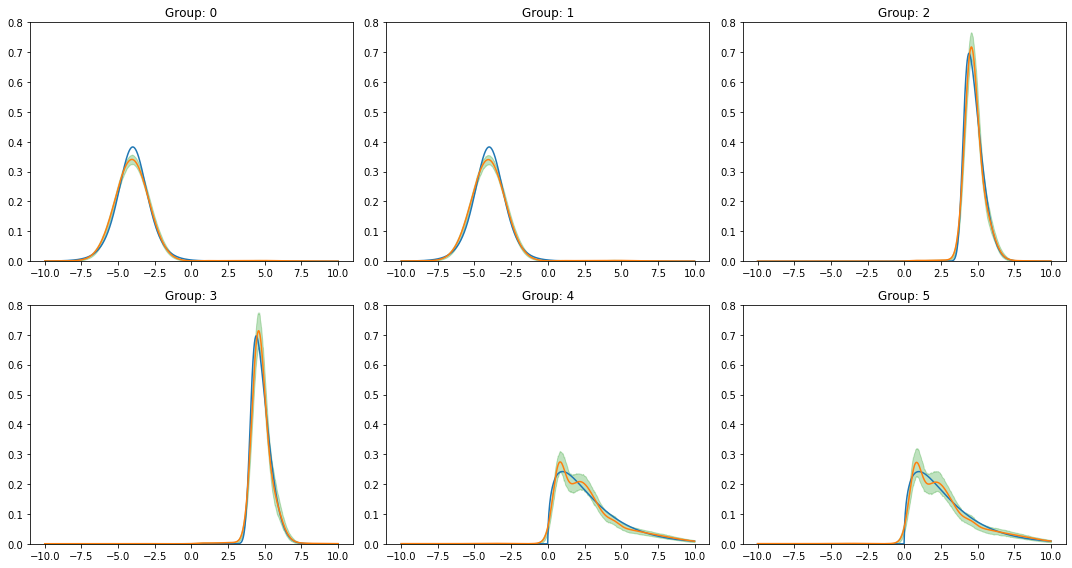

In [11]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))
axes = axes.flat

for g in range(numGroups):
    axes[g].plot(xgrid, true_d[g])
    axes[g].plot(xgrid, np.mean(dens[g], 0))
    axes[g].set_ylim([0, 0.8])
    intervals = np.array([pm.stats.hpd(dens[g][:, i], 0.05) for i in range(dens[g].shape[1])])
    axes[g].fill_between(xgrid, intervals[:, 0], intervals[:, 1], alpha=0.3, color=current_palette[2])
    axes[g].set_title("Group: {0}".format(g))
#     sns.kdeplot(datas[g], ax=axes[g], color=current_palette[3])
    
plt.tight_layout()

In [ ]:
# plot densities

import matplotlib
import plotly
import plotly.graph_objects as go


# da cambiare in base al plot
g = -1
true = true_d[g]

estimated = np.mean(dens[g], 0)

intervals = np.array([pm.stats.hpd(dens[g][:, i], 0.05) for i in range(dens[g].shape[1])])

# --------------------

#colors

color_true = 'rgba(255,140,0, 1)'
color_true_area = 'rgba(255,140,0, 0.)'

color_estimated = 'rgba(15, 32, 67, 1)'
color_estimated_area = 'rgba(15, 32, 67, 0.)'

color_intervals = 'rgba(122, 207, 221, 0.7)'

fig = go.Figure()

# true density
fig.add_trace(go.Scatter(x=xgrid,
                         y=true,
                         showlegend=False,
                         mode='lines',
                         line=dict(width=3, 
                                   color=color_true),
                         fill='tozeroy',
                         fillcolor=color_true_area,
                         ))

# estimated density
fig.add_trace(go.Scatter(x=xgrid,
                         y=estimated,
                         showlegend=False,
                         mode='lines',
                         line=dict(width=3, 
                                   color=color_estimated),
                         fill='tozeroy',
                         fillcolor=color_estimated_area,
                         ))

# Crebible intervals
fig.add_trace(go.Scatter(x=xgrid,
                         y=intervals[:, 0],
                         showlegend=False,
                         mode=None,
                         line=dict(width=0, 
                                   color=color_intervals),
                         ))
fig.add_trace(go.Scatter(x=xgrid,
                         y=intervals[:, 1],
                         showlegend=True,
                         name = '95% Credible Interval',
                         mode=None,
                         line=dict(width=0, 
                                   color=color_intervals),
                         fill='tonexty',
                         fillcolor=color_intervals,
                         ))

# estimated density
fig.add_trace(go.Scatter(x=xgrid,
                         y=estimated,
                         showlegend=True,
                         name='Estimated Density',
                         mode='lines',
                         line=dict(width=3, 
                                   color=color_estimated),
                         ))

# true density
fig.add_trace(go.Scatter(x=xgrid,
                         y=true,
                         showlegend=True,
                         name='True Density',
                         mode='lines',
                         line=dict(width=3, 
                                   color=color_true),
                         ))



fig.update_layout(
            plot_bgcolor='rgba(0, 0, 0, 0)',
            )
fig.update_xaxes(showgrid=True, gridwidth=0.5, gridcolor='grey',
                 zeroline=True, zerolinewidth=0.5, zerolinecolor='grey')
fig.update_yaxes(showgrid=True, gridwidth=0.5, gridcolor='grey',
                 zeroline=True, zerolinewidth=0.5, zerolinecolor='grey',
                range=[0, 0.7])

plotly.offline.iplot(fig)

## HDP

Now we want to compare our results with the estimates obtained with Hierarchical Dirichlet Process.  

We expect the results to be close on the first dataset, but to have an edge, at least 

In [15]:
subprocess.call(
    "./spatial_mix/run_hdp_from_file.out"
    " ./notebooks/SIS/approximate_pdf/data/simulation_1.csv"
    " ./notebooks/SIS/approximate_pdf/data/chains_hdp_simulation_1.recordio".split())

0

In [16]:
hdpChains = loadChains("./notebooks/SIS/approximate_pdf/data/chains_hdp_simulation_1.recordio", HdpState)

In [17]:
densHdp = hdp_utils.estimateDensities(hdpChains, xgrid)

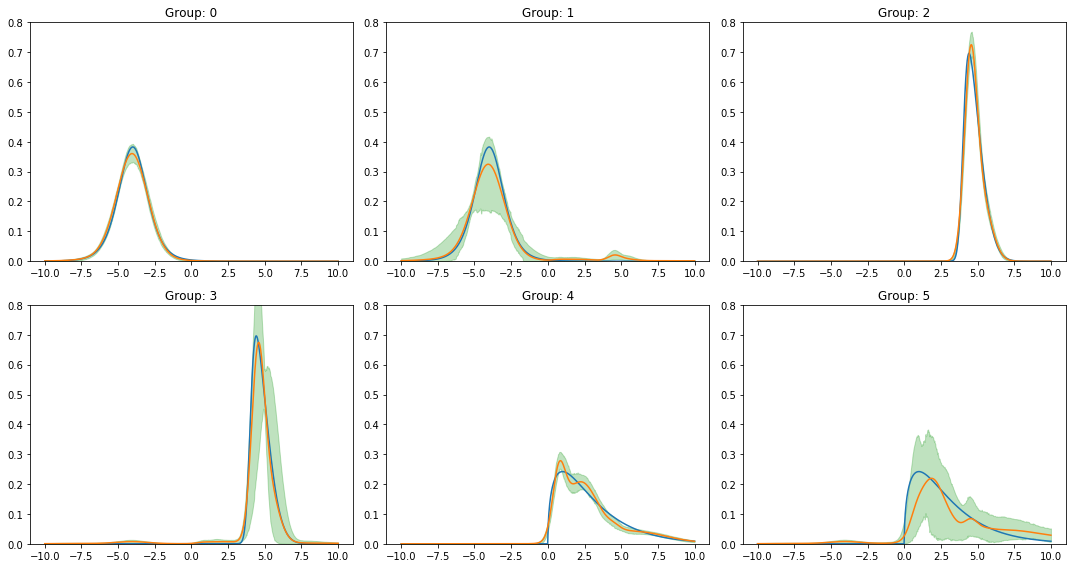

In [18]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))
axes = axes.flat

for g in range(numGroups):
    axes[g].plot(xgrid,true_d[g]) 
    obs = df[df["group"] == g]["datum"].values
    # sns.kdeplot(obs, ax=axes[g])
    axes[g].set_ylim([0, 0.8])
    axes[g].plot(xgrid, np.mean(densHdp[g], 0))
    intervals = np.array([pm.stats.hpd(densHdp[g][:, i], 0.05) for i in range(densHdp[g].shape[1])])
    axes[g].fill_between(xgrid, intervals[:, 0], intervals[:, 1], alpha=0.3, color=current_palette[2])
    axes[g].set_title("Group: {0}".format(g))
    
plt.tight_layout()

## Comparison

We can visually compare the credible intervals in the plots above. And then we compare the closedness of the extimates in terms of the Hellinger distance.

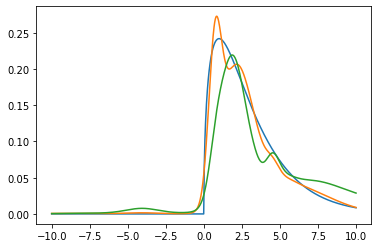

In [23]:
g = 5
plt.plot(xgrid, true_d[g])
plt.plot(xgrid, np.mean(dens[g], 0))
plt.plot(xgrid, np.mean(densHdp[g], 0))
plt.show()

In [24]:
hellinger_dist(np.mean(dens[g], 0), true_d[g], xgrid)

0.05213669548259894

In [25]:
hellinger_dist(np.mean(densHdp[g], 0), true_d[g], xgrid)

0.11829192814084018

In [26]:
for g in range(numGroups):
    print("OUR: {0:.3f}, HDP: {1:.3f}".format(
        np.mean(post_hellinger_dist(true_d[g], dens[g], xgrid)),
        np.mean(post_hellinger_dist(true_d[g], densHdp[g], xgrid))))

OUR: 6.666, HDP: 6.649
OUR: 6.669, HDP: 6.774
OUR: 8.566, HDP: 8.492
OUR: 8.572, HDP: 8.696
OUR: 5.825, HDP: 5.789
OUR: 5.828, HDP: 5.861


In [ ]:
for g in range(numGroups):
    print(hellinger_dist(np.mean(densHdp[g], 0), np.mean(dens[g], 0), xgrid))
    

In [27]:
hellinger_dist(true_d[g], np.mean(densHdp[g], 0), xgrid)

0.11829192814084018

In [28]:
hellinger_dist(true_d[g], densHdp[g][0, :], xgrid)

0.19425803635067415

In [29]:
hellinger_dist(true_d[g], densHdp[g][1, :], xgrid)

0.0808828250506606

In [30]:
post_hellinger_dist(true_d[g], densHdp[g][:1, :], xgrid)

[array([5.9978371]),
 array([5.9978371]),
 array([5.9978371]),
 array([5.9978371]),
 array([5.9978371]),
 array([5.9978371]),
 array([5.9978371]),
 array([5.9978371]),
 array([5.9978371]),
 array([5.9978371]),
 array([5.9978371]),
 array([5.9978371]),
 array([5.9978371]),
 array([5.9978371]),
 array([5.9978371]),
 array([5.9978371]),
 array([5.9978371]),
 array([5.9978371]),
 array([5.9978371]),
 array([5.9978371]),
 array([5.9978371]),
 array([5.9978371]),
 array([5.9978371]),
 array([5.9978371]),
 array([5.9978371]),
 array([5.9978371]),
 array([5.9978371]),
 array([5.9978371]),
 array([5.9978371]),
 array([5.9978371]),
 array([5.9978371]),
 array([5.9978371]),
 array([5.9978371]),
 array([5.9978371]),
 array([5.9978371]),
 array([5.9978371]),
 array([5.9978371]),
 array([5.9978371]),
 array([5.9978371]),
 array([5.9978371]),
 array([5.9978371]),
 array([5.9978371]),
 array([5.9978371]),
 array([5.9978371]),
 array([5.9978371]),
 array([5.9978371]),
 array([5.9978371]),
 array([5.997

In [33]:
densHdp[g][:2, :].shape

(2, 1000)

array([0.19425804, 0.08088283])